<a href="https://colab.research.google.com/github/trtrgfh/fast.ai-Course/blob/main/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !unzip /content/gdrive/MyDrive/images.zip
# !rm -rf <folder_name>

# Prepare Data

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
import pickle

In [4]:
# Get cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.manual_seed(1234)
transform = transforms.Compose([
  transforms.Resize((224, 224)),  # Resize the image to a desired size
  transforms.ToTensor(),  # Convert the image to a tensor
  # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [6]:
# Load the images from the folders and create the dataset
def load_images_from_folder(folder, label):
  images = []
  for filename in os.listdir(folder):
    if filename.endswith(".jpg"):
      file_path = os.path.join(folder, filename)
      image = Image.open(file_path).convert("RGB")
      images.append(transform(image))
  labels = [label] * len(images)
  return images, labels

In [7]:
# Get training data
train_flip, train_flip_labels = load_images_from_folder("/Users/yehao/Desktop/Apziva/MonReader/images/training/flip", 1)
train_non_flip, train_non_flip_labels = load_images_from_folder("/Users/yehao/Desktop/Apziva/MonReader/images/training/notflip", 0)

train_images = train_flip + train_non_flip
train_labels = train_flip_labels + train_non_flip_labels

# Get testing data
test_flip, test_flip_labels = load_images_from_folder("/Users/yehao/Desktop/Apziva/MonReader/images/testing/flip", 1)
test_non_flip, test_non_flip_labels = load_images_from_folder("/Users/yehao/Desktop/Apziva/MonReader/images/testing/notflip", 0)

test_images = test_flip + test_non_flip
test_labels = test_flip_labels + test_non_flip_labels

In [8]:
print(f"number of training images:", len(train_images))
print(f"training images shape:", train_images[0].shape)
print(f"number of testing images:", len(test_images))
print(f"testing images shape:", test_images[0].shape)

number of training images: 2392
training images shape: torch.Size([3, 224, 224])
number of testing images: 597
testing images shape: torch.Size([3, 224, 224])


In [9]:
# m = # of examples, train_data[m][0] is the features, train_data[m][1] is the labels
train_data = torch.utils.data.TensorDataset(torch.stack(train_images), torch.LongTensor(train_labels))
test_data = torch.utils.data.TensorDataset(torch.stack(test_images), torch.LongTensor(test_labels))
batch_size = 32

# Create a DataLoader to load the data in batches for training
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a testing DataLoader, no need to shuffle for testing
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
# Define the CNN model
# "SAME" padding = ceil((f - 1) / 2)
model = nn.Sequential(
  nn.Conv2d(3, 8, kernel_size=4, stride=1, padding=2),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=8, stride=8, padding=4),
  nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=1),
  nn.ReLU(),
  nn.MaxPool2d(kernel_size=4, stride=4, padding=2),
  nn.Flatten(),
  nn.Linear(16 * 8 * 8, 2),
  nn.Softmax(dim=1)
)

In [11]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
def test_model(model, loss_fn):
    # Testing
    test_loss, test_acc = 0, 0
    final_y_pred = []
    model.eval()
    with torch.inference_mode():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss
            test_acc += (torch.eq(labels, outputs.argmax(dim=1)).sum().item() / len(outputs)) * 100
            
            final_y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        f1 = f1_score(test_labels, final_y_pred)

    return test_loss, test_acc, f1, final_y_pred

In [13]:
def train_model(model, loss_fn, optimizer, num_epochs, model_name, include_test=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = 0, 0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            # Forward pass
            outputs = model(images)
    
            # Calculate loss
            loss = loss_fn(outputs, labels)
            train_loss += loss
            train_acc += (torch.eq(labels, outputs.argmax(dim=1)).sum().item() / len(outputs)) * 100

            # Optimizer zero grad
            optimizer.zero_grad()
        
            # Loss backward
            loss.backward()
        
            # Optimizer step
            optimizer.step()
    
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        print(f"Epoch: {epoch+1}")
        if include_test:
            # Testing
            test_loss, test_acc, f1, _ = test_model(model, loss_fn)
            print(f"Train_loss: {train_loss:.4f}, Test_loss: {test_loss:.4f}, Train_acc: {train_acc:.4f}, Test_acc: {test_acc:.4f}, f1: {f1:.4f}")
        else:
            print(f"Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.4f}")
        
    # Save trained model
    with open(model_name, 'wb') as file:
        pickle.dump(model, file)

In [14]:
torch.manual_seed(1234)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

train_model(model, loss_fn, optimizer, num_epochs, "cnn_model.pkl")

Epoch: 1
Train_loss: 0.6820, Test_loss: 0.6540, Train_acc: 56.3194, Test_acc: 67.5047, f1: 0.5776
Epoch: 2
Train_loss: 0.6235, Test_loss: 0.5965, Train_acc: 68.4028, Test_acc: 69.9405, f1: 0.7230
Epoch: 3
Train_loss: 0.5769, Test_loss: 0.5285, Train_acc: 73.6944, Test_acc: 85.2679, f1: 0.8370
Epoch: 4
Train_loss: 0.5088, Test_loss: 0.4675, Train_acc: 83.7361, Test_acc: 90.0454, f1: 0.8921
Epoch: 5
Train_loss: 0.4775, Test_loss: 0.4415, Train_acc: 86.3333, Test_acc: 90.2099, f1: 0.8933
Epoch: 6
Train_loss: 0.4350, Test_loss: 0.4284, Train_acc: 90.1944, Test_acc: 91.6823, f1: 0.9182
Epoch: 7
Train_loss: 0.4120, Test_loss: 0.4070, Train_acc: 92.5139, Test_acc: 92.3481, f1: 0.9190
Epoch: 8
Train_loss: 0.3969, Test_loss: 0.3976, Train_acc: 93.2222, Test_acc: 93.4994, f1: 0.9319
Epoch: 9
Train_loss: 0.3886, Test_loss: 0.3890, Train_acc: 93.8750, Test_acc: 92.6770, f1: 0.9225
Epoch: 10
Train_loss: 0.3892, Test_loss: 0.3983, Train_acc: 93.8194, Test_acc: 93.1626, f1: 0.9333


In [15]:
test_loss, test_acc, f1, final_y_pred = test_model(model, loss_fn)

In [16]:
mismatched_indices = np.where(np.array(final_y_pred) != np.array(test_labels))[0]

In [17]:
random_mismatched = np.random.choice(mismatched_indices, size=10, replace=False)

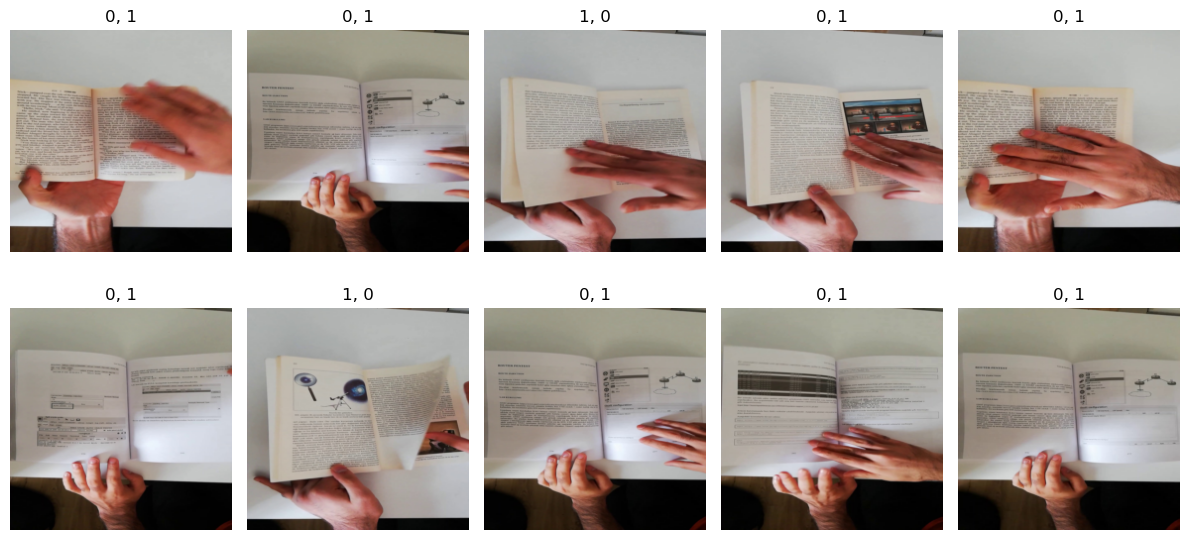

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Assuming test_images is a list of tensor images
for i, index in enumerate(random_mismatched):
  image = test_images[index]

  # Convert tensor to NumPy array
  np_image = image.numpy()

  # Transpose dimensions to (height, width, channels)
  np_image = np.transpose(np_image, (1, 2, 0))

  # Plot the image in the current subplot
  ax = axs[i // 5, i % 5]
  ax.imshow(np_image)
  ax.axis('off')

  # Set the label on top of the image
  ax.set_title(f"{test_labels[index]}, {final_y_pred[index]}")

plt.tight_layout()
plt.show()

# ResNet

In [19]:
class IdentityBlock(nn.Module):
  def __init__(self, in_channels, f, filters, stride=1):
    super(IdentityBlock, self).__init__()
    F1, F2, F3 = filters

    self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, padding=0, stride=stride, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(F1)
    self.conv2 = nn.Conv2d(F1, F2, kernel_size=f, padding=f//2, stride=stride, bias=False)
    self.batch_norm2 = nn.BatchNorm2d(F2)
    self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, padding=0, stride=stride, bias=False)
    self.batch_norm3 = nn.BatchNorm2d(F3)

    self.stride = stride
    self.relu = nn.ReLU()

    # kaiming_uniform_ initializer is default
    # nn.init.kaiming_uniform_(self.conv1.weight)
    # nn.init.kaiming_uniform_(self.conv2.weight)
    # nn.init.kaiming_uniform_(self.conv3.weight)

  def forward(self, x):
    shortcut = x

    out = self.conv1(x)
    out = self.batch_norm1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.batch_norm2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.batch_norm3(out)

    out += shortcut
    out = self.relu(out)
    return out

In [20]:
class ConvolutionalBlock(nn.Module):
  def __init__(self, in_channels, f, filters, stride=2):
    super(ConvolutionalBlock, self).__init__()
    F1, F2, F3 = filters

    self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, padding=0, stride=stride, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(F1)
    self.conv2 = nn.Conv2d(F1, F2, kernel_size=f, padding=f//2, stride=1, bias=False)
    self.batch_norm2 = nn.BatchNorm2d(F2)
    self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, padding=0, stride=1, bias=False)
    self.batch_norm3 = nn.BatchNorm2d(F3)

    self.shortcut = nn.Conv2d(in_channels, F3, kernel_size=1, padding=0, stride=stride, bias=False)
    self.shortcut_bn = nn.BatchNorm2d(F3)

    self.stride = stride
    self.relu = nn.ReLU()

  def forward(self, x):
    shortcut = x

    out = self.conv1(x)
    out = self.batch_norm1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.batch_norm2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.batch_norm3(out)

    shortcut = self.shortcut(shortcut)
    shortcut = self.shortcut_bn(shortcut)

    out += shortcut
    out = self.relu(out)
    return out

In [21]:
# Define the ResNet50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv_block1 = ConvolutionalBlock(64, f=3, filters=[64, 64, 256], stride=1)
        self.id_block1 = IdentityBlock(256, 3, [64, 64, 256])
        self.id_block2 = IdentityBlock(256, 3, [64, 64, 256])

        self.conv_block2 = ConvolutionalBlock(256, f=3, filters=[128, 128, 512], stride=2)
        self.id_block3 = IdentityBlock(512, 3, [128, 128, 512])
        self.id_block4 = IdentityBlock(512, 3, [128, 128, 512])
        self.id_block5 = IdentityBlock(512, 3, [128, 128, 512])

        self.conv_block3 = ConvolutionalBlock(512, f=3, filters=[256, 256, 1024], stride=2)
        self.id_block6 = IdentityBlock(1024, 3, [256, 256, 1024])
        self.id_block7 = IdentityBlock(1024, 3, [256, 256, 1024])
        self.id_block8 = IdentityBlock(1024, 3, [256, 256, 1024])
        self.id_block9 = IdentityBlock(1024, 3, [256, 256, 1024])
        self.id_block10 = IdentityBlock(1024, 3, [256, 256, 1024])

        self.conv_block4 = ConvolutionalBlock(1024, f=3, filters=[512, 512, 2048], stride=2)
        self.id_block11 = IdentityBlock(2048, 3, [512, 512, 2048])
        self.id_block12 = IdentityBlock(2048, 3, [512, 512, 2048])

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.conv_block1(x)
        x = self.id_block1(x)
        x = self.id_block2(x)

        x = self.conv_block2(x)
        x = self.id_block3(x)
        x = self.id_block4(x)
        x = self.id_block5(x)

        x = self.conv_block3(x)
        x = self.id_block6(x)
        x = self.id_block7(x)
        x = self.id_block8(x)
        x = self.id_block9(x)
        x = self.id_block10(x)

        x = self.conv_block4(x)
        x = self.id_block11(x)
        x = self.id_block12(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.output(x)

        return x

In [22]:
resnet50_model = ResNet50(2)

In [23]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

train_model(resnet50_model, loss_fn, optimizer, num_epochs, "resnet50_model.pkl", include_test=False)

Epoch: 1
Train_loss: 0.6338, Train_acc: 66.9444
Epoch: 2
Train_loss: 0.4950, Train_acc: 81.4722
Epoch: 3
Train_loss: 0.4588, Train_acc: 85.1944
Epoch: 4
Train_loss: 0.4705, Train_acc: 83.9583
Epoch: 5
Train_loss: 0.4459, Train_acc: 86.4861
Epoch: 6
Train_loss: 0.4463, Train_acc: 86.2778
Epoch: 7
Train_loss: 0.4254, Train_acc: 88.6944
Epoch: 8
Train_loss: 0.4204, Train_acc: 89.0833
Epoch: 9
Train_loss: 0.4159, Train_acc: 89.5139
Epoch: 10
Train_loss: 0.3938, Train_acc: 91.8472


In [24]:
test_loss, test_acc, f1, final_y_pred = test_model(resnet50_model, loss_fn)
print(f"Test_loss: {test_loss}, Test_acc: {test_acc}, f1: {f1}")

Test_loss: 0.3802967071533203, Test_acc: 93.1704260651629, f1: 0.9266547406082289


# MobileNet

In [25]:
import torchvision

In [26]:
weights = torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2

In [27]:
mobile_model = torchvision.models.mobilenet_v2(weights=weights)

In [28]:
in_features = mobile_model.classifier[1].in_features
mobile_model.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

In [29]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobile_model.parameters(), lr=0.001)

# Training loop
num_epochs = 3

train_model(mobile_model, loss_fn, optimizer, num_epochs, "mobile_model.pkl", include_test=False)

Epoch: 1
Train_loss: 0.1539, Train_acc: 93.3611
Epoch: 2
Train_loss: 0.0359, Train_acc: 99.0556
Epoch: 3
Train_loss: 0.0381, Train_acc: 98.6944


In [30]:
torch.manual_seed(1234)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc, f1, final_y_pred = test_model(mobile_model, loss_fn)
print(f"Test_loss: {test_loss}, Test_acc: {test_acc}, f1: {f1}")

Test_loss: 0.06093967705965042, Test_acc: 98.51973684210526, f1: 0.9842931937172775


In [31]:
# Save trained model
with open("mobilenet_model.pkl", 'wb') as file:
    pickle.dump(mobile_model, file)